In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
df_train=pd.read_csv("./train.csv")
df_test=pd.read_csv("./test.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#数据清洗

#保存训练集的Survived
survived_train=df_train.Survived
#将训练集和测试集union,为了处理确实数据和数据数字化
data=pd.concat([df_train.drop(['Survived'],axis=1),df_test])
data.info()
#可以看出Age,Embarked,Cabin有数据丢失

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [5]:
#填充NAN数据
data['Age']=data.Age.fillna(data.Age.median())
data['Fare']=data.Fare.fillna(data.Fare.median())
data['Embarked']=data.Embarked.fillna('S')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [6]:
#将Sex数字化
data=pd.get_dummies(data,columns=['Sex','Embarked'],drop_first=True)

In [7]:
data=data[['Pclass','Age','SibSp','Parch','Fare','Sex_male','Embarked_Q','Embarked_S']]
data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


In [8]:
#数据归一化
#age
ageMean=data.Age.mean()
ageMax=data.Age.max()
data['Age']=data.Age.apply(lambda x:(x-ageMean)/ageMax)
#fare
fareMean=data.Fare.mean()
fareMax=data.Fare.max()
data['Fare']=data.Fare.apply(lambda x:(x-fareMean)/fareMax)
#Parch
parchMean=data.Parch.mean()
parchMax=data.Parch.max()
data['Parch']=data.Parch.apply(lambda x:(x-parchMean)/parchMax)
data.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,-0.09379,1,-0.042781,-0.050809,1,0,1
1,1,0.10621,1,-0.042781,0.074175,0,0,0
2,3,-0.04379,0,-0.042781,-0.049492,0,0,1
3,1,0.06871,1,-0.042781,0.038684,0,0,1
4,3,0.06871,0,-0.042781,-0.049248,1,0,1


In [9]:
#将训练集和测试集分离
data_train=data.iloc[:891]
data_test=data.iloc[891:]
target=survived_train

In [10]:
#将训练集分为训练集,交叉校验集,测试集合
tmp_data,test_data,tmp_target,test_target=train_test_split(data_train,target,test_size=0.2,random_state=42)
train_data,cv_data,train_target,cv_target=train_test_split(tmp_data,tmp_target,test_size=0.25,random_state=42)
train_data=train_data.T
cv_data=cv_data.T
test_data=test_data.T
train_target=train_target.values.reshape((1,train_target.shape[0]))
cv_target=cv_target.values.reshape(1,cv_target.shape[0])
test_target=test_target.values.reshape(1,test_target.shape[0])
print(train_data.shape,train_target.shape,cv_data.shape,cv_target.shape)

((8, 534), (1, 534), (8, 178), (1, 178))


In [316]:
#第一层的激活函数使用tanh
def g1(z1):
    z=np.copy(z1)
    z=np.where(z>=0,z,0.01*z)
    return z
def g1Prime(z1):
    z=np.copy(z1)
    z=np.where(z>=0,1,0.01)
    return z
#第二层的激活函数使用sigmod
def g2(z2):
    return 1/(1+np.exp(-z2))
def g2Prime(z2):
    a=g2(z2)
    return a-np.square(a)

In [239]:
def test(k):
    k2=np.copy(k)
    k2=np.where(k2>=1,3,2)
    print(k2)
k=np.array([0,1,2])
test(k)
k

[2 3 3]


array([0, 1, 2])

In [27]:
#使用两层的神经网络处理线性不可分的数据
#第零层为数据输入层
#第二层为隐藏层(神经元个数为8)
#第三层为输出层(神经元个数为1)
def AnnIteraterNumber(train_data,cv_data,iteraterNumber):
    ln=0.9
    x=train_data
    m=x.shape[1]
    hidden_node=8
    w1=np.random.randn(hidden_node,x.shape[0])*0.01
    b1=np.zeros((hidden_node,1))
    w2=np.random.randn(1,hidden_node)*0.01
    b2=np.zeros((1,1))
    for batch in iteraterNumber:
        for i in xrange(batch):
            z1=np.dot(w1,x)+b1
            a1=g1(z1)
            z2=np.dot(w2,a1)+b2
            a2=g2(z2)
            #cost function
            L=np.sum(-(target*np.log(a2)+(1-target)*np.log(1-a2)),axis=1,keepdims=True)/m
            dz2=a2-target
            dw2=np.dot(dz2,a1.T)/m
            db2=np.sum(dz2,axis=1,keepdims=True)/m
            dz1=np.dot(w2.T,dz2)*g1Prime(z1)
            dw1=np.dot(dz1,x.T)/m
            db1=np.sum(dz1)/m
            w2-=ln*dw2
            b2-=ln*db2
            w1-=ln*dw1
            b1-=ln*db1
        print(L)

In [384]:
#使用两层的神经网络处理线性不可分的数据
#第零层为数据输入层
#第二层为隐藏层(神经元个数为8)
#第三层为输出层(神经元个数为1)
def AnnHiddenNodeNumber(train_data,cv_data,train_target,hidden1NodeNumber):
    ln=0.5
    x=train_data
    target=train_target
    m=x.shape[1]
    hidden_node=hidden1NodeNumber
    w1=np.random.randn(hidden_node,x.shape[0])*0.01
    b1=np.zeros((hidden_node,1))
    w2=np.random.randn(1,hidden_node)*0.01
    b2=np.zeros((1,1))
    train_target=np.zeros((1,train_data.shape[1]),dtype=int)
    cv_target=np.zeros((1,cv_data.shape[1]),dtype=int)
    L=None
    for batch in [5000]:
        for i in xrange(batch):
            z1=np.dot(w1,x)+b1
            a1=g1(z1)
            z2=np.dot(w2,a1)+b2
            a2=g2(z2)
            #cost function
            L=np.sum(-(target*np.log(a2)+(1-target)*np.log(1-a2)),axis=1,keepdims=True)/m
            dz2=a2-target
            dw2=np.dot(dz2,a1.T)/m
            db2=np.sum(dz2,axis=1,keepdims=True)/m
            dz1=np.dot(w2.T,dz2)*g1Prime(z1)
            dw1=np.dot(dz1,x.T)/m
            db1=np.sum(dz1)/m
            w2-=ln*dw2
            b2-=ln*db2
            w1-=ln*dw1
            b1-=ln*db1
        train_target[a2>=0.5]=1
        z1=np.dot(w1,cv_data)+b1
        a1=g1(z1)
        z2=np.dot(w2,a1)+b2
        cv_a2=g2(z2)
        cv_target[cv_a2>=0.5]=1
        print(L)
    return train_target,cv_target,w2,b2,w1,b1
        

[[0.41618087]]
[[0.39489803]]
[[0.37568392]]
[[0.37602814]]
[[0.34804636]]
[[0.33860835]]
[[0.33482309]]
[[0.37479094]]
[[0.32717787]]
[[0.33124681]]
[[0.33133023]]
[[0.3207983]]
[[0.33190657]]
[[0.31806463]]
[[0.32368438]]
[[0.3253598]]
[[0.32120102]]
[[0.31564531]]


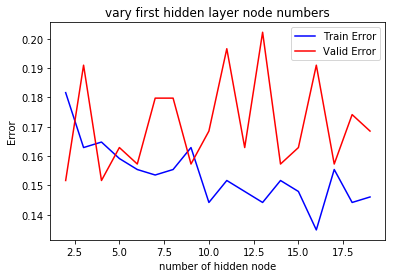

In [12]:
accurate_train=[]
accurate_cv=[]
nodeNumbers=range(2,20)
for i in nodeNumbers:
    train_target_tmp,cv_target_tmp,_,_,_,_=AnnHiddenNodeNumber(train_data,cv_data,train_target,i)
    res_train_target=train_target_tmp==train_target
    res_cv_target=cv_target_tmp==cv_target
    accurate_train_tmp=len(res_train_target[res_train_target==False])/float(len(res_train_target[0]))
    accurate_cv_tmp=len(res_cv_target[res_cv_target==False])/float(len(res_cv_target[0]))
    accurate_train.append(accurate_train_tmp)
    accurate_cv.append(accurate_cv_tmp)
plt.title("vary first hidden layer node numbers")
plt.plot(nodeNumbers,accurate_train,"b-",label="Train Error")
plt.plot(nodeNumbers,accurate_cv,"r-",label="Valid Error")
plt.legend()
plt.xlabel("number of hidden node")
plt.ylabel("Error")
plt.show()

In [416]:
  _,_,w2,b2,w1,b1=AnnHiddenNodeNumber(train_data,cv_data,train_target,6)

[[0.44887787]]


In [100]:
test_data=data_test.T
z1=np.dot(w1,test_data)+b1
a1=g1(z1)
z2=np.dot(w2,a1)+b2
a2=g2(z2)
test_target_tmp=np.zeros((1,test_data.shape[1]),dtype=int)
test_target[0][a2[0]>=0.5]=1
df_test['Survived']=test_target[0]
df_test[['PassengerId','Survived']].to_csv("./test_target.csv",index=False)

In [314]:
#使用两层的神经网络处理线性不可分的数据
#第零层为数据输入层
#第二层为隐藏层(神经元个数为8)
#第三层为输出层(神经元个数为1)
def AnnDataNumber(train_data,cv_data,test_data,train_target,hidden1NodeNumber):
    ln=0.2
    x=train_data
    target=train_target
    m=x.shape[1]
    hidden_node=hidden1NodeNumber
    w1=np.random.randn(hidden_node,x.shape[0])*0.01
    b1=np.zeros((hidden_node,1))
    w2=np.random.randn(1,hidden_node)*0.01
    b2=np.zeros((1,1))
    train_target=np.zeros((1,train_data.shape[1]),dtype=int)
    cv_target=np.zeros((1,cv_data.shape[1]),dtype=int)
    test_target=np.zeros((1,test_data.shape[1]),dtype=int)
    L=None
    a2=None
    wl=[]
    bl=[]
    for batch in [3000]:
        for i in xrange(batch):
            z1=np.dot(w1,x)+b1
            a1=g1(z1)
            z2=np.dot(w2,a1)+b2
            a2=g2(z2)
            #cost function
            L=np.sum(-(target*np.log(a2)+(1-target)*np.log(1-a2)),axis=1,keepdims=True)/m
            dz2=a2-target
            dw2=np.dot(dz2,a1.T)/m
            db2=np.sum(dz2,axis=1,keepdims=True)/m
            dz1=np.dot(w2.T,dz2)*g1Prime(z1)
            dw1=np.dot(dz1,x.T)/m
            db1=np.sum(dz1)/m
            w2-=ln*dw2
            b2-=ln*db2
            w1-=ln*dw1
            b1-=ln*db1
        train_target[a2>=0.5]=1
        z1=np.dot(w1,cv_data)+b1
        a1=g1(z1)
        z2=np.dot(w2,a1)+b2
        cv_a2=g2(z2)
        cv_target[cv_a2>=0.5]=1
        
        z1=np.dot(w1,test_data)+b1
        a1=g1(z1)
        z2=np.dot(w2,a1)+b2
        test_a2=g2(z2)
        test_target[test_a2>=0.5]=1
        print(L)
        wl.append(w1)
        wl.append(w2)
        bl.append(b1)
        bl.append(b2)
    return train_target,cv_target,test_target,wl,bl
        

[[0.49441614]]
[[0.41778294]]
[[0.36313185]]
[[0.43055919]]
[[0.38898086]]
[[0.41326184]]
[[0.44468008]]
[[0.43340765]]
[[0.4473661]]


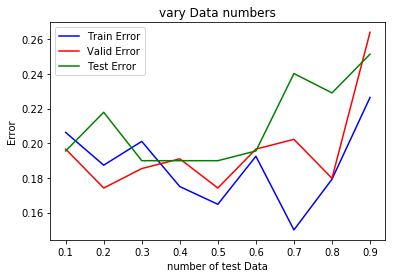

In [317]:
accurate_train=[]
accurate_cv=[]
accurate_test=[]
w=[]
b=[]
dataSplitNumbers=[0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
for i in dataSplitNumbers:
    split_train_data,_,split_train_target,_=train_test_split(train_data.T,train_target.T,test_size=i,random_state=42)
    split_train_data=split_train_data.T
    split_train_target=split_train_target.T
    train_target_tmp,cv_target_tmp,test_target_tmp,wl,bl=AnnDataNumber(split_train_data,cv_data,test_data,split_train_target,2)
    w.append(wl)
    b.append(bl)
    res_train_target=train_target_tmp==split_train_target
    res_cv_target=cv_target_tmp==cv_target
    res_test_target=test_target_tmp==test_target
    accurate_train_tmp=len(res_train_target[res_train_target==False])/float(len(res_train_target[0]))
    accurate_cv_tmp=len(res_cv_target[res_cv_target==False])/float(len(res_cv_target[0]))
    accurate_test_tmp=len(res_test_target[res_test_target==False])/float(len(res_test_target[0]))
    accurate_train.append(accurate_train_tmp)
    accurate_cv.append(accurate_cv_tmp)
    accurate_test.append(accurate_test_tmp)
plt.title("vary Data numbers")
plt.plot(dataSplitNumbers,accurate_train,"b-",label="Train Error")
plt.plot(dataSplitNumbers,accurate_cv,"r-",label="Valid Error")
plt.plot(dataSplitNumbers,accurate_test,"g-",label="Test Error")
plt.legend()
plt.xlabel("number of test Data")
plt.ylabel("Error")
plt.show() 

In [295]:
w1=w[8][0]
w2=w[8][1]
b1=b[8][0]
b2=b[8][1]
z1=np.dot(w1,data_test.T)+b1
a1=g1(z1)
z2=np.dot(w2,a1)+b2
a2=g2(z2)
test_target_tmp=np.zeros((1,data_test.T.shape[1]),dtype=int)
test_target_tmp[0][a2[0]>=0.5]=1
df_test['Survived']=test_target_tmp[0]
df_test[['PassengerId','Survived']].to_csv("./test_target.csv",index=False)

In [11]:
#第一层的激活函数使用tanh
def tanh(z1):
    return (np.exp(z1)-np.exp(-z1))/(np.exp(z1)+np.exp(-z1))
def tanhPrime(z1):
    a=tanh(z1)
    return 1-np.square(a)
#第二层的激活函数使用sigmod
def sigmod(z2):
    return 1/(1+np.exp(-z2))
def sigmodPrime(z2):
    a=sigmod(z2)
    return a-np.square(a)

In [34]:
#使用两层的神经网络处理线性不可分的数据
#第零层为数据输入层
#第一层为隐藏层(神经元个数为10)
#第二层为输出层(神经元个数为2)
#第三层为输出层(神经元个数为1)
def Ann2HiddenNodeNumber(train_data,cv_data,test_data,train_target,hidden1Nodes,hidden2Nodes):
    ln=1.5
    x=train_data
    target=train_target
    m=x.shape[1]
    n0=x.shape[0]
    n1=hidden1Nodes
    n2=hidden2Nodes
    n3=1
    w1=np.random.randn(n1,n0)*0.01
    b1=np.zeros((n1,1))
    w2=np.random.randn(n2,n1)*0.01
    b2=np.zeros((n2,1))
    w3=np.random.randn(n3,n2)
    b3=np.zeros((n3,1))
    L=None
    a3=None
    wl=[]
    bl=[]
    train_target=np.zeros((1,train_data.shape[1]),dtype=int)
    cv_target=np.zeros((1,cv_data.shape[1]),dtype=int)
    test_target=np.zeros((1,test_data.shape[1]),dtype=int)
    for i in xrange(5000):
        z1=np.dot(w1,x)+b1
        a1=tanh(z1)
        z2=np.dot(w2,a1)+b2
        a2=tanh(z2)
        z3=np.dot(w3,a2)+b3
        a3=sigmod(z3)
        #cost function
        L=np.sum(-(target*np.log(a3)+(1-target)*np.log(1-a3)),axis=1,keepdims=True)/m
        dz3=a3-target
        dw3=np.dot(dz3,a2.T)/m
        db3=np.sum(dz3,axis=1,keepdims=True)/m
        dz2=np.dot(w3.T,dz3)*tanhPrime(z2)
        dw2=np.dot(dz2,a1.T)/m
        db2=np.sum(dz2,axis=1,keepdims=True)/m
        dz1=np.dot(w2.T,dz2)*tanhPrime(z1)
        dw1=np.dot(dz1,x.T)/m
        db1=np.sum(dz1)/m
        w3-=ln*dw3
        b3-=ln*db3
        w2-=ln*dw2
        b2-=ln*db2
        w1-=ln*dw1
        b1-=ln*db1
    train_target[a3>=0.5]=1
    z1=np.dot(w1,cv_data)+b1
    a1=tanh(z1)
    z2=np.dot(w2,a1)+b2
    a2=tanh(z2)
    z3=np.dot(w3,a2)+b3
    cv_a3=sigmod(z3)
    cv_target[cv_a3>=0.5]=1
    z1=np.dot(w1,test_data)+b1
    a1=tanh(z1)
    z2=np.dot(w2,a1)+b2
    a2=tanh(z2)
    z3=np.dot(w3,a2)+b3
    test_a3=sigmod(z3)
    test_target[test_a3>0.5]=1
    print(L)
    wl.append(w1)
    wl.append(w2)
    wl.append(w3)
    bl.append(b1)
    bl.append(b2)
    bl.append(b3)
    return train_target,cv_target,test_target,wl,bl

[[0.41202164]]
[[0.42841745]]
[[0.37982078]]
[[0.40768116]]
[[0.37417197]]


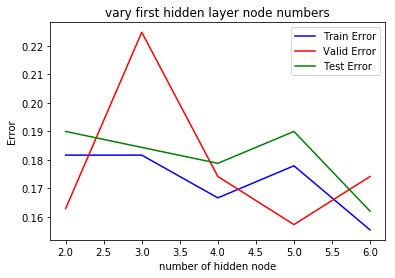

In [39]:
accurate_train=[]
accurate_cv=[]
accurate_test=[]
w=[]
b=[]
hidden2Nodes=range(2,7)
for i in hidden2Nodes:
    train_target_tmp,cv_target_tmp,test_target_tmp,wl,bl=Ann2HiddenNodeNumber(train_data,cv_data,test_data,train_target,hidden1Nodes=4,hidden2Nodes=i)
    w.append(wl)
    b.append(bl)
    res_train_target=train_target_tmp==train_target
    res_cv_target=cv_target_tmp==cv_target
    res_test_target=test_target_tmp==test_target
    accurate_train_tmp=len(res_train_target[res_train_target==False])/float(len(res_train_target[0]))
    accurate_cv_tmp=len(res_cv_target[res_cv_target==False])/float(len(res_cv_target[0]))
    accurate_test_tmp=len(res_test_target[res_test_target==False])/float(len(res_test_target[0]))
    accurate_train.append(accurate_train_tmp)
    accurate_cv.append(accurate_cv_tmp)
    accurate_test.append(accurate_test_tmp)
plt.title("vary first hidden layer node numbers")
plt.plot(hidden2Nodes,accurate_train,"b-",label="Train Error")
plt.plot(hidden2Nodes,accurate_cv,"r-",label="Valid Error")
plt.plot(hidden2Nodes,accurate_test,"g-",label="Test Error")
plt.legend()
plt.xlabel("number of hidden node")
plt.ylabel("Error")
plt.show()

In [37]:
print(test_target,train_target,cv_target)

(array([[1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1]]), array([[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 

In [42]:
w1=w[4][0]
w2=w[4][1]
w3=w[4][2]
b1=b[4][0]
b2=b[4][1]
b3=b[4][2]
x=data_test.T
z1=np.dot(w1,x)+b1
a1=tanh(z1)
z2=np.dot(w2,a1)+b2
a2=tanh(z2)
z3=np.dot(w3,a2)+b3
a3=sigmod(z3)
test_target_tmp=np.zeros((1,x.shape[1]),dtype=int)
test_target_tmp[0][a3[0]>=0.5]=1
df_test['Survived']=test_target_tmp[0]
df_test[['PassengerId','Survived']].to_csv("./test_target.csv",index=False)

In [331]:
#使用两层的神经网络处理线性不可分的数据
#第零层为数据输入层
#第一层为隐藏层(神经元个数为10)
#第二层为输出层(神经元个数为2)
#第三层为输出层(神经元个数为1)
def Ann2HiddenNodeNumber(train_data,cv_data,test_data,train_target,hidden1Nodes,hidden2Nodes,hidden3Nodes):
    ln=0.1
    x=train_data
    target=train_target
    m=x.shape[1]
    n0=x.shape[0]
    n1=hidden1Nodes
    n2=hidden2Nodes
    n3=hidden3Nodes
    n4=1
    w1=np.random.randn(n1,n0)*0.01
    b1=np.zeros((n1,1))
    w2=np.random.randn(n2,n1)*0.01
    b2=np.zeros((n2,1))
    w3=np.random.randn(n3,n2)
    b3=np.zeros((n3,1))
    w4=np.random.randn(n4,n3)
    b4=np.zeros((n4,1))
    L=None
    a4=None
    train_target=np.zeros((1,train_data.shape[1]),dtype=int)
    cv_target=np.zeros((1,cv_data.shape[1]),dtype=int)
    test_target=np.zeros((1,test_data.shape[1]),dtype=int)
    for i in xrange(8900):
        z1=np.dot(w1,x)+b1
        a1=tanh(z1)
        z2=np.dot(w2,a1)+b2
        a2=tanh(z2)
        z3=np.dot(w3,a2)+b3
        a3=tanh(z3)
        z4=np.dot(w4,a3)+b4
        a4=sigmod(z4)
        #cost function
        L=np.sum(-(target*np.log(a4)+(1-target)*np.log(1-a4)),axis=1,keepdims=True)/m
        dz4=a4-target
        dw4=np.dot(dz4,a3.T)/m
        db4=np.sum(dz4,axis=1,keepdims=True)/m
        dz3=np.dot(w4.T,dz4)
        dw3=np.dot(dz3,a2.T)/m
        db3=np.sum(dz3,axis=1,keepdims=True)/m
        dz2=np.dot(w3.T,dz3)*tanhPrime(z2)
        dw2=np.dot(dz2,a1.T)/m
        db2=np.sum(dz2,axis=1,keepdims=True)/m
        dz1=np.dot(w2.T,dz2)*tanhPrime(z1)
        dw1=np.dot(dz1,x.T)/m
        db1=np.sum(dz1)/m
        w4-=ln*dw4
        b3-=ln*b3
        w3-=ln*dw3
        b3-=ln*db3
        w2-=ln*dw2
        b2-=ln*db2
        w1-=ln*dw1
        b1-=ln*db1
    train_target[a4>=0.5]=1
    z1=np.dot(w1,cv_data)+b1
    a1=tanh(z1)
    z2=np.dot(w2,a1)+b2
    a2=tanh(z2)
    z3=np.dot(w3,a2)+b3
    a3=tanh(z3)
    z4=np.dot(w4,a3)+b4
    cv_a3=sigmod(z4)
    cv_target[cv_a3>=0.5]=1
    z1=np.dot(w1,test_data)+b1
    a1=tanh(z1)
    z2=np.dot(w2,a1)+b2
    a2=tanh(z2)
    z3=np.dot(w3,a2)+b3
    a3=tanh(z3)
    z4=np.dot(w4,a3)+b4
    test_a3=sigmod(z4)
    test_target[test_a3>=0.5]=1
    print(L)
    return train_target,cv_target,test_target,w3,b3,w2,b2,w1,b1

In [118]:
accurate_train=[]
accurate_cv=[]
accurate_test=[]
hidden2Nodes=range(2,7)
for i in hidden2Nodes:
    train_target_tmp,cv_target_tmp,test_target_tmp,_,_,_,_,_,_=Ann2HiddenNodeNumber(train_data,cv_data,test_data,train_target,hidden1Nodes=1,hidden2Nodes=1,hidden3Nodes=i)
    res_train_target=train_target_tmp==train_target
    res_cv_target=cv_target_tmp==cv_target
    res_test_target=test_target_tmp==test_target
    accurate_train_tmp=len(res_train_target[res_train_target==False])/float(len(res_train_target[0]))
    accurate_cv_tmp=len(res_cv_target[res_cv_target==False])/float(len(res_cv_target[0]))
    accurate_test_tmp=len(res_test_target[res_test_target==False])/float(len(res_test_target[0]))
    accurate_train.append(accurate_train_tmp)
    accurate_cv.append(accurate_cv_tmp)
    accurate_test.append(accurate_test_tmp)
plt.title("vary first hidden layer node numbers")
plt.plot(hidden2Nodes,accurate_train,"b-",label="Train Error")
plt.plot(hidden2Nodes,accurate_cv,"r-",label="Valid Error")
plt.plot(hidden2Nodes,accurate_test,"g-",label="Test Error")
plt.legend()
plt.xlabel("number of hidden node")
plt.ylabel("Error")
plt.show()

TypeError: Ann2HiddenNodeNumber() got an unexpected keyword argument 'hidden3Nodes'